# **家登預知保養**

目標：建立保養需求預測的AI模型

資料源：350TB設備IoT參數，21個欄位

期間：2022/5/19~2021/8/5

## **Deep Learning for Predictive Maintenance**

事實證明，深度學習在某些領域（例如對象識別和圖像分類）表現出卓越的性能`,在時間序列數據起著重要作用。預測性維護也是一個領域，在該領域中，隨著時間的推移收集數據以監視資產的狀態，目的是發現模式以預測故障，這些故障也可以從某些深度學習算法中受益。在深度學習方法中，長短期記憶（LSTM）網絡特別擅長預測性維護領域，因為它們非常擅長從序列中學習。通過使時間回溯更長的時間來檢測故障模式，這一事實使其適合於使用時間序列數據的應用程序。

在此筆記本中，我們為預測性維護模板中描述的數據集和場景建立了LSTM網絡，以工具機的剩餘保養時間。總之，該模型使用設備PLC或傳感器值來預測將來工具機何時需要保養，以便可以做為與計劃性保養得比照。


一般而言，預知保養有三種建模方式。

1. 回歸：預測剩餘使用壽命（RUL）或失效時間（TTF）。

2. 二進制分類：預測資產在特定時間範圍內（例如幾天）是否會失敗。

3. 多類分類：預測資產是否會在不同的時間範圍內失敗：例如，在[1，w0 ]天之內失敗；在[ w0 +1，w1 ]天的窗口中失敗；在w1天內不會失敗

本方法結合1.與2.來進行


## 載入必要的程式庫與資料源

In [1]:
import keras

In [2]:
import pandas as pd
import numpy as np
import codecs
import csv
import os

In [3]:
!gdown --id 1QlBZA4uf9jwUx8BCjlniemOpjl14Mhfp

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QlBZA4uf9jwUx8BCjlniemOpjl14Mhfp
To: /content/350TB_data_clean.csv
100% 3.42M/3.42M [00:00<00:00, 204MB/s]


In [4]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
#!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

#自己雲端硬碟的備份
!gdown --id 15u0IlxpEWAyZaAVgf1v0IQcDk8huSptC


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15u0IlxpEWAyZaAVgf1v0IQcDk8huSptC
To: /content/TaipeiSansTCBeta-Regular.ttf
100% 20.7M/20.7M [00:00<00:00, 62.5MB/s]


In [5]:
# 讀取資料源
from datetime import datetime

df2 = pd.read_csv('350TB_data_clean.csv',header=0)
df2.drop(df2.columns[[0]], axis=1, inplace=True)
df2['傳入時間'] = pd.to_datetime(df2['傳入時間'])
df2.head()

,傳入時間,射膠最大壓力,保壓最大壓力,射膠切保壓壓力,鎖模力,射膠終點,保壓終點,加料終點,射膠切保壓位置,射膠起點,加料起點,射膠時間,加料時間,週期時間,開模時間,關模時間,頂針時間,螺桿轉速,總射膠時間,模次
0,2022-05-19 01:27:00,87.4,80.9,80.8,78.5,8.3,8.4,130,11.0,131.2,12.5,4.19,24.41,60.9,5.70,5.02,0.92,0,6.32,236
1,2022-05-19 01:26:00,87.7,80.9,80.7,78.3,8.3,8.3,130,11.0,131.3,12.4,4.19,24.19,61.0,5.70,5.00,0.92,0,6.32,235
2,2022-05-19 01:25:00,88.0,81.4,81.2,79.0,8.3,8.3,130,11.0,131.3,12.4,4.20,24.27,60.9,5.70,5.02,0.92,0,6.32,234
3,2022-05-19 01:24:00,87.9,81.1,81.0,78.3,8.3,8.3,130,11.0,131.3,12.4,4.20,24.18,61.0,5.69,5.02,0.92,0,6.32,233
4,2022-05-19 01:22:00,87.7,81.1,80.7,78.5,8.3,8.4,130,11.0,131.3,12.5,4.19,24.14,61.0,5.69,5.00,0.92,0,6.32,232


In [6]:
# 畫圖程式庫與字型
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [7]:
'''
from matplotlib import font_manager
fontP = font_manager.FontProperties()
fontP.set_family('Taipei Sans TC Beta')
fontP.set_size(14)

sns.set(rc={'figure.figsize':(20, 4)})
df2.groupby('傳入時間').count().plot(y='模次',kind="bar")
# Note the next lines
plt.legend(loc=0, prop=fontP)
plt.xlabel("傳入時間",fontproperties=fontP)
plt.ylabel("次數",fontproperties=fontP)

plt.grid(True)
plt.axis('tight')
'''

'\nfrom matplotlib import font_manager\nfontP = font_manager.FontProperties()\nfontP.set_family(\'Taipei Sans TC Beta\')\nfontP.set_size(14)\n\nsns.set(rc={\'figure.figsize\':(20, 4)})\ndf2.groupby(\'傳入時間\').count().plot(y=\'模次\',kind="bar")\n# Note the next lines\nplt.legend(loc=0, prop=fontP)\nplt.xlabel("傳入時間",fontproperties=fontP)\nplt.ylabel("次數",fontproperties=fontP)\n\nplt.grid(True)\nplt.axis(\'tight\')\n'

In [8]:
# 將資料切段，目前依據每月保養時間，做切分
# 4月
pd.options.mode.chained_assignment = None  # default='warn'
df3 = df2[(df2['傳入時間'] >= '2022-04-19')& (df2['傳入時間'] <= '2022-05-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 12
df_all = df3

# 3月
pd.options.mode.chained_assignment = None  # default='warn'
df3 = df2[(df2['傳入時間'] >= '2022-03-19')& (df2['傳入時間'] <= '2022-04-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 11
df_all = df_all.append(df3, ignore_index = True)

# 2月 
df3 = df2[(df2['傳入時間'] >= '2022-02-19')& (df2['傳入時間'] <= '2022-03-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 9
df_all = df_all.append(df3, ignore_index = True)

# 1月 
df3 = df2[(df2['傳入時間'] >= '2022-01-19')& (df2['傳入時間'] <= '2022-02-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 7
df_all = df_all.append(df3, ignore_index = True)

# 12月
df3 = df2[(df2['傳入時間'] >= '2021-12-19')& (df2['傳入時間'] <= '2022-01-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 6
df_all = df_all.append(df3, ignore_index = True)

# 11月 
df3 = df2[(df2['傳入時間'] >= '2021-11-19')& (df2['傳入時間'] <= '2021-12-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 5
df_all = df_all.append(df3, ignore_index = True)

# 10月 
df3 = df2[(df2['傳入時間'] >= '2021-10-19')& (df2['傳入時間'] <= '2021-11-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 4
df_all = df_all.append(df3, ignore_index = True)

# 9月 
df3 = df2[(df2['傳入時間'] >= '2021-09-19')& (df2['傳入時間'] <= '2021-10-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 3
df_all = df_all.append(df3, ignore_index = True)

# 8月 
df3 = df2[(df2['傳入時間'] >= '2021-08-01')& (df2['傳入時間'] <= '2021-9-18')]
df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
df3['id']= 2
df_all = df_all.append(df3, ignore_index = True)

# 7月 
#df3 = df2[(df2['傳入時間'] >= '2021-07-19')& (df2['傳入時間'] <= '2021-8-18')]
#df3['cycle']= df3['傳入時間'].rank(ascending=1,method='dense').astype(int)
#df3['id']= 1
#df_all = df_all.append(df3, ignore_index = True)

In [9]:
# 重新依據'傳入時間'排序，確保資料不錯亂
df_all = df_all.sort_values(by=['傳入時間'],ascending=[True],ignore_index=True)
df_all

,傳入時間,射膠最大壓力,保壓最大壓力,射膠切保壓壓力,鎖模力,射膠終點,保壓終點,加料終點,射膠切保壓位置,射膠起點,...,加料時間,週期時間,開模時間,關模時間,頂針時間,螺桿轉速,總射膠時間,模次,cycle,id
0,2021-08-05 09:24:00,35.0,45.0,33.0,755.0,20.4,20.5,120,29.0,119.0,...,32.60,71.0,5.90,5.90,11.00,0,13.22,1,1,2
1,2021-08-05 09:26:00,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,...,27.30,82.6,5.80,5.90,10.90,0,13.78,2,2,2
2,2021-08-05 09:29:00,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,...,27.30,82.6,5.80,5.90,10.90,0,13.78,3,3,2
3,2021-08-05 09:33:00,34.0,45.0,33.0,764.0,23.2,23.3,120,29.0,123.5,...,29.60,83.3,5.80,5.90,11.10,0,13.78,4,4,2
4,2021-08-05 09:40:00,35.0,45.0,34.0,770.0,22.5,22.6,120,29.1,122.9,...,28.50,77.5,5.80,5.90,11.00,0,14.68,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,2022-05-17 23:54:00,85.7,75.8,75.2,80.1,8.1,8.2,130,11.5,131.2,...,24.82,70.9,5.87,5.22,0.90,0,5.76,567,4623,12
21418,2022-05-17 23:55:00,85.6,76.1,75.4,79.9,8.1,8.2,130,11.5,131.2,...,24.87,70.9,5.87,5.24,0.90,0,5.76,568,4624,12
21419,2022-05-17 23:57:00,85.9,76.3,75.8,80.0,8.1,8.2,130,11.5,131.2,...,24.89,70.9,5.87,5.24,0.92,0,5.76,569,4625,12
21420,2022-05-17 23:58:00,85.7,76.3,75.6,80.2,8.2,8.2,130,11.5,131.2,...,25.01,70.9,5.87,5.24,0.92,0,5.76,570,4626,12


In [10]:
# 去除'傳入時間'欄位
df_all.drop(df_all.columns[[0]], axis=1, inplace=True)
df_all

,射膠最大壓力,保壓最大壓力,射膠切保壓壓力,鎖模力,射膠終點,保壓終點,加料終點,射膠切保壓位置,射膠起點,加料起點,...,加料時間,週期時間,開模時間,關模時間,頂針時間,螺桿轉速,總射膠時間,模次,cycle,id
0,35.0,45.0,33.0,755.0,20.4,20.5,120,29.0,119.0,25.4,...,32.60,71.0,5.90,5.90,11.00,0,13.22,1,1,2
1,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,27.30,82.6,5.80,5.90,10.90,0,13.78,2,2,2
2,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,27.30,82.6,5.80,5.90,10.90,0,13.78,3,3,2
3,34.0,45.0,33.0,764.0,23.2,23.3,120,29.0,123.5,28.4,...,29.60,83.3,5.80,5.90,11.10,0,13.78,4,4,2
4,35.0,45.0,34.0,770.0,22.5,22.6,120,29.1,122.9,27.6,...,28.50,77.5,5.80,5.90,11.00,0,14.68,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,85.7,75.8,75.2,80.1,8.1,8.2,130,11.5,131.2,12.3,...,24.82,70.9,5.87,5.22,0.90,0,5.76,567,4623,12
21418,85.6,76.1,75.4,79.9,8.1,8.2,130,11.5,131.2,12.4,...,24.87,70.9,5.87,5.24,0.90,0,5.76,568,4624,12
21419,85.9,76.3,75.8,80.0,8.1,8.2,130,11.5,131.2,12.3,...,24.89,70.9,5.87,5.24,0.92,0,5.76,569,4625,12
21420,85.7,76.3,75.6,80.2,8.2,8.2,130,11.5,131.2,12.4,...,25.01,70.9,5.87,5.24,0.92,0,5.76,570,4626,12


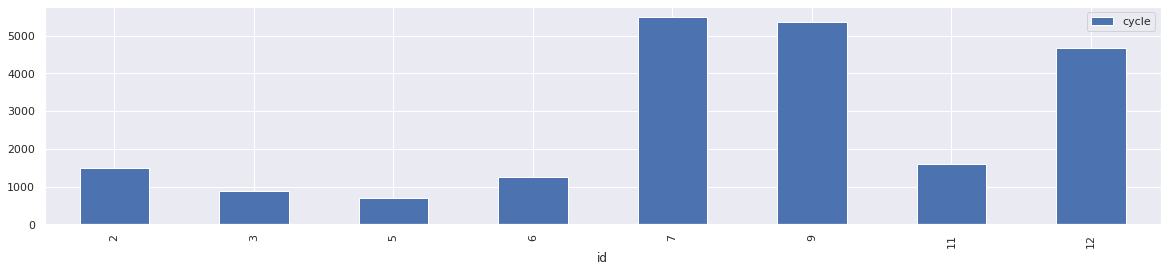

In [11]:
# 依編號，看一下分布
sns.set(rc={'figure.figsize':(20, 4)})
df_all.groupby('id').count().plot(y='cycle',kind="bar")

訓練數據包含多個以“週期”為時間單位的多元時間序列，以及每個週期的N個傳感器讀數。 可以將每個時間序列假定為由相同類型的不同生產批次。 測試數據具有與訓練數據相同的數據模式。 唯一的區別是該數據不指示何時發生故障。

## **Modelling** 建模

傳統的預測維護機器學習模型基於特徵工程，即使用領域專業知識和類似方法手動構建正確的特徵。這通常會使這些模型難以重用，因為特徵工程是特定於問題場景的，並且可用數據因企業而異。在預測性維護領域中應用深度學習最吸引人的部分可能是這些網絡可以自動從數據中提取正確的特徵，而無需進行人工特徵工程。

在時序域中使用LSTM時，要選擇的一個重要參數是序列長度，它是LSTM回溯的窗口。可以將其視為類似於在預測維護模型中選擇：

window_size = 5

週期來計算滾動特徵，即N個傳感器值的滾動平均值和滾動標準偏差。使用LSTM的想法是讓模型從窗口中的傳感器值序列中提取抽象特徵，而不是手動進行工程設計。可以預期的是，如果在發生故障之前窗口內的這些傳感器值中存在模式，則該模式應由LSTM編碼。

LSTM的一個關鍵優勢是它們能夠記住長期序列（窗口大小）的能力，這是傳統特徵工程難以實現的。例如，由於在如此長的時間內對值進行平滑和抽象化，因此在50個週期的窗口大小上計算滾動平均值可能會導致信息丟失，相反，使用所有50個值作為輸入可能會提供更好的結果。雖然大窗口尺寸的特徵工程可能沒有意義，但LSTM能夠使用更大的窗口尺寸，並將窗口中的所有信息用作輸入。

In [12]:
# 載入LSTM相關程式庫
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

%matplotlib inline

In [13]:
# pick a large window size of 50 cycles
#sequence_length = 5
#sequence_length = 2

In [14]:
# 新增必要資料標籤 RUL - Data Labeling: generate column RUL
rul = pd.DataFrame(df_all.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
df_all_0 = df_all.merge(rul, on=['id'], how='left')
df_all_0['RUL'] = df_all_0['max'] - df_all_0['cycle']
df_all_0.drop('max', axis=1, inplace=True)
df_all_0.head()

,射膠最大壓力,保壓最大壓力,射膠切保壓壓力,鎖模力,射膠終點,保壓終點,加料終點,射膠切保壓位置,射膠起點,加料起點,...,週期時間,開模時間,關模時間,頂針時間,螺桿轉速,總射膠時間,模次,cycle,id,RUL
0,35.0,45.0,33.0,755.0,20.4,20.5,120,29.0,119.0,25.4,...,71.0,5.9,5.9,11.0,0,13.22,1,1,2,1476
1,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,82.6,5.8,5.9,10.9,0,13.78,2,2,2,1475
2,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,82.6,5.8,5.9,10.9,0,13.78,3,3,2,1474
3,34.0,45.0,33.0,764.0,23.2,23.3,120,29.0,123.5,28.4,...,83.3,5.8,5.9,11.1,0,13.78,4,4,2,1473
4,35.0,45.0,34.0,770.0,22.5,22.6,120,29.1,122.9,27.6,...,77.5,5.8,5.9,11.0,0,14.68,5,5,2,1472


In [15]:
# 新增必要資料標籤 w0, w1  - generate label columns w0 and w1 for test data
# w1 第一次倒數警告、 w0 第二次倒數警告
w1 = 200
w0 = 100
df_all_0['label1'] = np.where(df_all_0['RUL'] <= w1, 1, 0 )
df_all_0['label2'] = df_all_0['label1']
df_all_0.loc[df_all_0['RUL'] <= w0, 'label2'] = 2
df_all_0.head()

,射膠最大壓力,保壓最大壓力,射膠切保壓壓力,鎖模力,射膠終點,保壓終點,加料終點,射膠切保壓位置,射膠起點,加料起點,...,關模時間,頂針時間,螺桿轉速,總射膠時間,模次,cycle,id,RUL,label1,label2
0,35.0,45.0,33.0,755.0,20.4,20.5,120,29.0,119.0,25.4,...,5.9,11.0,0,13.22,1,1,2,1476,0,0
1,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,5.9,10.9,0,13.78,2,2,2,1475,0,0
2,34.0,45.0,32.0,757.0,22.4,22.4,120,29.1,123.7,27.6,...,5.9,10.9,0,13.78,3,3,2,1474,0,0
3,34.0,45.0,33.0,764.0,23.2,23.3,120,29.0,123.5,28.4,...,5.9,11.1,0,13.78,4,4,2,1473,0,0
4,35.0,45.0,34.0,770.0,22.5,22.6,120,29.1,122.9,27.6,...,5.9,11.0,0,14.68,5,5,2,1472,0,0


In [16]:
# 建立 windows
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, namen = list(),list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        namen +=[('sensor%d(t-%d)' %(j+1, i)) for j in range (n_vars)]
        #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            namen +=[('sensor%d(t)' %(j+1)) for j in range (n_vars)]
        else:
            namen +=[('sensor%d(t+%d)' '%'(j+1, i)) for j in range (n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns=namen
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
# 資料預處理 preprocessing (德) 
def Vorverarbeitung_Y(data):
    from sklearn import preprocessing

    #Label Mapping
    le = preprocessing.LabelEncoder()
    le.fit(data)
    encoded_y=le.transform(data)
    #Get the Label map
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    return pd.DataFrame(encoded_y,columns=['target'])

In [18]:
senorname = ['射膠最大壓力', '保壓最大壓力', '射膠切保壓壓力', '鎖模力', '總射膠時間']

#MAP TARGETS TO VALUE    
encoded_y=Vorverarbeitung_Y(df_all_0['label1'])
Values=pd.concat([df_all_0[senorname],encoded_y],axis=1)#.reindex(data.index)

{0: 0, 1: 1}


In [19]:
Future=2
data_win=series_to_supervised(Values, n_in=Future, n_out=1)
to_remove_list =['sensor'+str(n)+'(t)' for n in range(1,len(Values.columns)+1)] #now remove all non shifted elements again. so we retreive elements and shifted target

data_y=data_win.iloc[:,-1] #Get the target data out before removing unwanted data
data_x=data_win.drop(to_remove_list, axis=1) #remove sensors(t)
data_x.drop(data_x.columns[len(data_x.columns)-1], axis=1, inplace=True)# remove target(t-n)

Text(10, 0, 'val data')

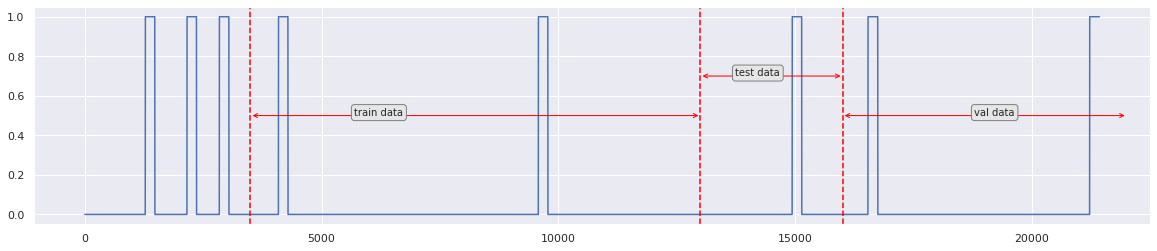

In [56]:
# 顯示 tain, test, validate data 的切法
ax = data_y.plot(figsize=(20,4))
ax.axvline(3500, color="red", linestyle="--") # test start
ax.axvline(13000, color="red", linestyle="--")
ax.axvline(16000, color="red", linestyle="--")

# 標記 test
ax.annotate("", xy=(3500, 0.5), xycoords='data', xytext=(13000, 0.5), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",color="red"),  )
ax.annotate('train data', xy=(6000, 0.5), xycoords='data', ha='center', xytext=(10, 0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", ec="gray"))

# 標記 test
ax.annotate("", xy=(13000, 0.7), xycoords='data', xytext=(16000, 0.7), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",color="red"),  )
ax.annotate('test data', xy=(14000, 0.7), xycoords='data', ha='center', xytext=(10, 0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", ec="gray"))

# 標記 validate
ax.annotate("", xy=(16000, 0.5), xycoords='data', xytext=(22000, 0.5), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",color="red"),  )
ax.annotate('val data', xy=(19000, 0.5), xycoords='data', ha='center', xytext=(10, 0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", ec="gray"))

In [20]:
data_x

,sensor1(t-2),sensor2(t-2),sensor3(t-2),sensor4(t-2),sensor5(t-2),sensor6(t-2),sensor1(t-1),sensor2(t-1),sensor3(t-1),sensor4(t-1),sensor5(t-1)
2,35.0,45.0,33.0,755.0,13.22,0.0,34.0,45.0,32.0,757.0,13.78
3,34.0,45.0,32.0,757.0,13.78,0.0,34.0,45.0,32.0,757.0,13.78
4,34.0,45.0,32.0,757.0,13.78,0.0,34.0,45.0,33.0,764.0,13.78
5,34.0,45.0,33.0,764.0,13.78,0.0,35.0,45.0,34.0,770.0,14.68
6,35.0,45.0,34.0,770.0,14.68,0.0,37.0,45.0,36.0,772.0,13.78
...,...,...,...,...,...,...,...,...,...,...,...
21417,85.7,75.4,74.9,79.8,5.76,1.0,85.4,73.9,73.3,80.1,5.74
21418,85.4,73.9,73.3,80.1,5.74,1.0,85.7,75.8,75.2,80.1,5.76
21419,85.7,75.8,75.2,80.1,5.76,1.0,85.6,76.1,75.4,79.9,5.76
21420,85.6,76.1,75.4,79.9,5.76,1.0,85.9,76.3,75.8,80.0,5.76


In [21]:
# 依據上面圖示，決定資料分割方式
def splitting_and_shape_data(data_x,data_y): 
    # 3500 - 13000 for train
    # 13000-16000 for test
    # 16000- for validate   
    train_X=data_x[3500:13000].values
    train_Y=data_y[3500:13000].values
    
    val_X=data_x[16000::].values
    val_Y=data_y[16000::].values
    
    test_X=data_x[13000:16000].values
    test_Y=data_y[13000:16000].values
      
    train_X.astype('float32')
    val_X.astype('float32')
    test_X.astype('float32')
    
    return train_X,train_Y,val_X,val_Y,test_X,test_Y,  

def one_hot(train_Y,val_Y,test_Y):    
    from sklearn.preprocessing import OneHotEncoder
    
    oneHot=OneHotEncoder()
    oneHot.fit(train_Y.reshape(-1,1))
    
    train_Y_Hot=oneHot.transform(train_Y.reshape(-1,1)).toarray()
    val_Y_Hot  =oneHot.transform(val_Y.reshape(-1,1)).toarray()
    test_Y_Hot =oneHot.transform(test_Y.reshape(-1,1)).toarray()
    
    return train_Y_Hot,val_Y_Hot,test_Y_Hot

In [22]:
train_X,train_Y,val_X,val_Y,test_X,test_Y=splitting_and_shape_data(data_x,data_y)
train_Y_Hot,val_Y_Hot,test_Y_Hot=one_hot(train_Y,val_Y,test_Y)

In [23]:
data_x

,sensor1(t-2),sensor2(t-2),sensor3(t-2),sensor4(t-2),sensor5(t-2),sensor6(t-2),sensor1(t-1),sensor2(t-1),sensor3(t-1),sensor4(t-1),sensor5(t-1)
2,35.0,45.0,33.0,755.0,13.22,0.0,34.0,45.0,32.0,757.0,13.78
3,34.0,45.0,32.0,757.0,13.78,0.0,34.0,45.0,32.0,757.0,13.78
4,34.0,45.0,32.0,757.0,13.78,0.0,34.0,45.0,33.0,764.0,13.78
5,34.0,45.0,33.0,764.0,13.78,0.0,35.0,45.0,34.0,770.0,14.68
6,35.0,45.0,34.0,770.0,14.68,0.0,37.0,45.0,36.0,772.0,13.78
...,...,...,...,...,...,...,...,...,...,...,...
21417,85.7,75.4,74.9,79.8,5.76,1.0,85.4,73.9,73.3,80.1,5.74
21418,85.4,73.9,73.3,80.1,5.74,1.0,85.7,75.8,75.2,80.1,5.76
21419,85.7,75.8,75.2,80.1,5.76,1.0,85.6,76.1,75.4,79.9,5.76
21420,85.6,76.1,75.4,79.9,5.76,1.0,85.9,76.3,75.8,80.0,5.76


In [24]:
# 將資料處理為LSTM使用的方式
def reshape_for_Lstm(data):    
    # reshape for input 
    timesteps=1
    samples=int(np.floor(data.shape[0]/timesteps))

    data=data.reshape((samples,timesteps,data.shape[1]))   #samples, timesteps, sensors     
    return data

MinMaxScaler 最小最大值標準化

在MinMaxScaler中是給定了一個明確的最大值與最小值。每個特徵中的最小值變成了0，最大值變成了1。數據會縮放到到[0,1]之間。

In [25]:
from sklearn.preprocessing import MinMaxScaler
# SCALE THE SETS BETWEEN 0-1
scaler=MinMaxScaler().fit(train_X)
train_X=scaler.transform(train_X) 

scaler=MinMaxScaler().fit(val_X)
val_X=scaler.transform(val_X)  

scaler=MinMaxScaler().fit(test_X)
test_X=scaler.transform(test_X)  

#RESHAPE THE DATA TO FIT LSTMs samples, timesteps, sensors  FORMAT
train_X=reshape_for_Lstm(train_X)
val_X=reshape_for_Lstm(val_X)
test_X=reshape_for_Lstm(test_X)

## **LSTM Network**

LSTM 的全名為 Long Short-Term Memory，是一般 RNN 的進階改良版。
LSTM 改良了 RNN 短期記憶的問題，能夠記住更早以前的資訊。LSTM 與一般 RNN 最大的不同之處在於「模型的運算過程」。LSTM 模型進行更複雜的運算。長短期記憶神經網路（LSTM）是一種特殊的迴圈神經網路(RNN)。原始的RNN在訓練中，隨著訓練時間的加長以及網路層數的增多，很容易出現梯度爆炸或者梯度消失的問題，導致無法處理較長序列資料，從而無法獲取長距離資料的資訊。

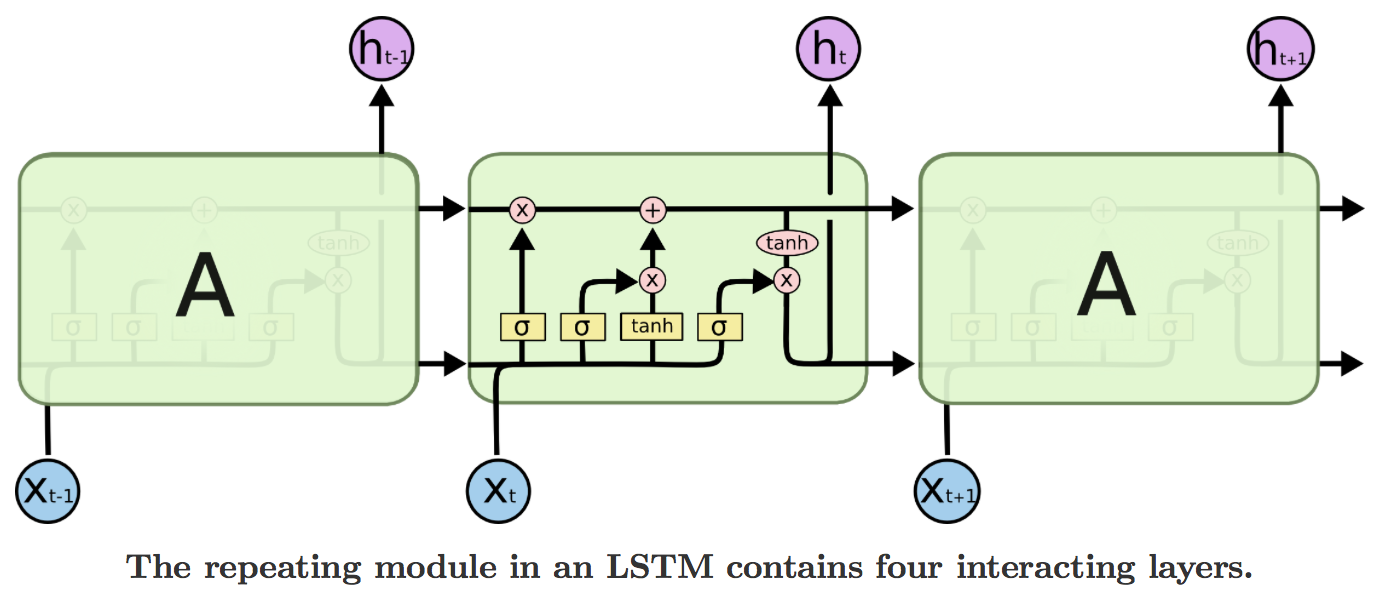

In [26]:
def plot_training(history,what='loss',saving=False,name='training'):
    fig=plt.figure()
    plt.plot(history[0])
    plt.plot(history[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    if what=='loss':
        plt.title('model loss')
        plt.ylabel('loss')
    elif what=='acc':   
        plt.title('model Acc')
        plt.ylabel('Accuracy')   
    if saving==True:
        fig.savefig( name +'_'+ what + '.png', format='png', dpi=300, transparent=True)


    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    if saving==True:
        fig.savefig( name +'_ACC.png', format='png', dpi=300, transparent=True)  
    plt.show()
    
def plot_signal_hat(Y_test,Y_hat,saving=False,name='results_signal'):
    fig= plt.figure(figsize=(15,3))

    plt.plot(Y_hat)
    plt.plot(Y_test)
    plt.legend(['target','target_predicted'])
    plt.ylabel('Zustand')
    plt.title('Pediction on test data')
    if saving==True:
        fig.savefig( name +'.png', format='png', dpi=300, transparent=True)
    plt.show()
        
def plot_class_hat(Y_hat,Y_test,saving=False,name='results_class'):   
    # HERE WE TRY TO PLOT MULTICOLOR BASED ON PROBABILITY VALUE, BUT IT DOES NOT WOR. IMPUT WELCOME
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import numpy as np
    x=np.linspace(1,len(Y_hat),len(Y_hat))

    fig=plt.figure(figsize=(15,3))
    ax1=fig.add_subplot(111)
    ax1=plt.plot(x,Y_test)
    ax1=plt.scatter(x,Y_hat,c=cm.hot(np.abs(Y_hat)), edgecolor='none') # multicolour print
    plt.legend(['target','target_predicted'])
    if saving==True:
        fig.savefig( name +'.png', format='png', dpi=300, transparent=True)
    plt.show()
 

## LSTM 模型


LSTM Layer 所接受的輸入必須為「三個維度」( 3-dimiension)。其中，第一個維度指的是 Batch Size，表示一個 Batch 中有多少個 Sample；第二個維度為 Time Step，表示一個 Sample 中由多少時間單位組成；第三個維度為 Input Dimension，表示 Sample 中的每一個時間單位的向量維度。

網路中的第一個隱藏層必須定義期望輸出的數量，例如輸入層的形狀。輸入必須是三維的，由樣本、時間步長和特徵組成。


樣本。它們是你資料中的行。一個樣本可以是一個序列。

時間步長。這些是對特徵的過去觀察值，例如滯後的變數。

特徵。這些是資料中的列。

本次模型由三層組成，兩層為以Relu為激勵函數的 LSTM結構，輸出數為42，輸出有兩種模式：訊號模式與類別模式，以因應預知保養的需求，參數量為23481，如下圖。

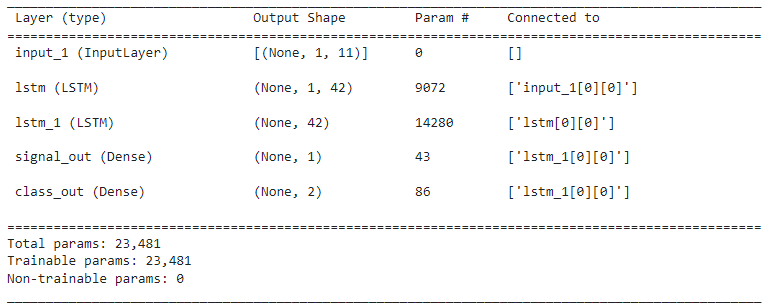

其中全連接層（Fully Connected Layer）因為相連緊密的特性，稱作 Dense layer，應用softmax作為類神經網路中激勵函數 (activation function)。所謂的激勵函數，以增加類神經網路裡頭的非線性特徵。

In [27]:
# 搭建 LSTM layer:
# units: 神經元的數目
# Compiling & Fitting LSTM model
# optimizer: 選擇 Adam
# loss: 使用 MSE

def model_setup_Fapi(in_shape):
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Dense
    
    inputs= tf.keras.Input(shape=(in_shape[1],in_shape[2]))
    x=LSTM(42,activation='relu', input_shape=(in_shape[1],in_shape[2]),return_sequences=True)(inputs)
    x=LSTM(42,activation='relu')(x)
    out_signal=Dense(1, name='signal_out')(x)
    out_class=Dense(2,activation='softmax', name='class_out')(x)
    
    model=tf.keras.Model(inputs=inputs, outputs=[out_signal,out_class])
    
    model.compile(loss={'signal_out':'mean_squared_error',
                        'class_out' :'categorical_crossentropy'},
                         optimizer='adam',
                         metrics={'class_out':'acc'})
    
    print(model.summary())
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 11)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 42)        9072        ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 42)           14280       ['lstm[0][0]']                   
                                                                                                  
 signal_out (Dense)             (None, 1)            43          ['lstm_1[0][0]']                 
                                                                                              

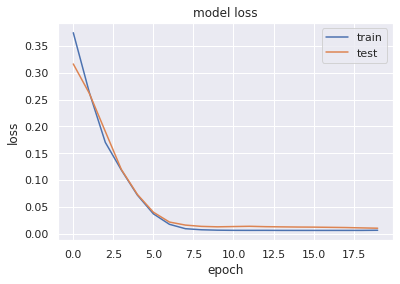

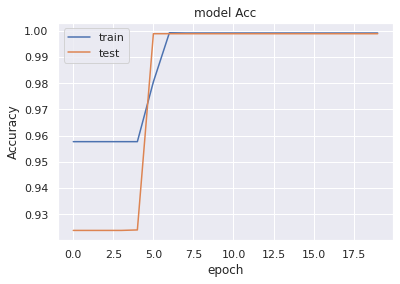

INFO:tensorflow:Assets written to: ./model/Pump_LSTM_Fapi_4_2/assets


In [28]:
import tensorflow as tf
# TRAIN THE MODEL...    
Train=True
inputshape_X=(train_X.shape)

if Train==True:
    #model=model_setup_seq(inputshape_X)
    #history = model.fit(train_X, train_Y, epochs=80, batch_size=32, validation_data=(val_X, val_Y), shuffle=False)

    model=model_setup_Fapi(inputshape_X)
    history = model.fit(train_X, [train_Y, train_Y_Hot], epochs=20, batch_size=32, validation_data=(val_X, [val_Y,val_Y_Hot]), shuffle=False)
    plot_training([history.history['class_out_loss'],history.history['val_class_out_loss']],
                  what='loss',
                  saving=True,
                  name=('training_'+ str(Future)))  
    plot_training([history.history['class_out_acc'],history.history['val_class_out_acc']],
                  what='acc',
                  saving=True,
                  name=('training_'+ str(Future))) 
    model.save('./model/Pump_LSTM_Fapi_4_'+ str(Future))
    
# ...OR LOAD THE MODELl  
else:  
    model=tf.keras.models.load_model('./model/Pump_LSTM_Fapi')

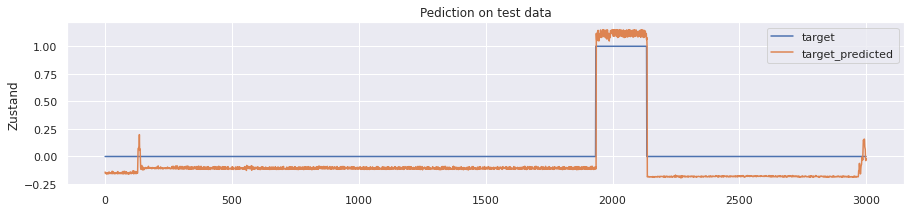

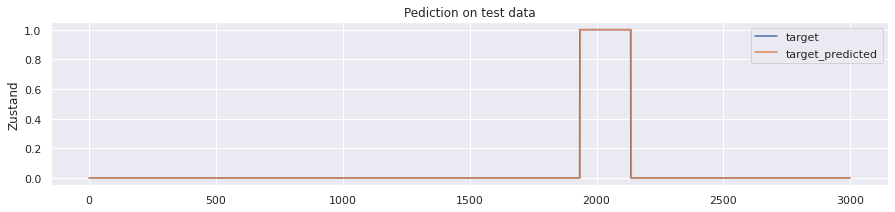

In [29]:
# 建立預測結果，並用圖例表示
[yhat,yclass] = model.predict(test_X)    
Yclass=[np.argmax(yclass[i],0) for i in range(len(yclass))] # get final class

plot_signal_hat(yhat,test_Y,saving=True, name='Prediction_Signal_fapi3_42_'+ str(Future))
plot_signal_hat(Yclass,test_Y,saving=True, name='Prediction_class_fapi3_42_'+ str(Future))

上圖test data的驗證圖示化，橘色部分為預測線圖，藍色部分為保養需求發生的設定線，透過特徵值的學習，其預測結果是理想的。

In [30]:
test_X.shape

(3000, 1, 11)

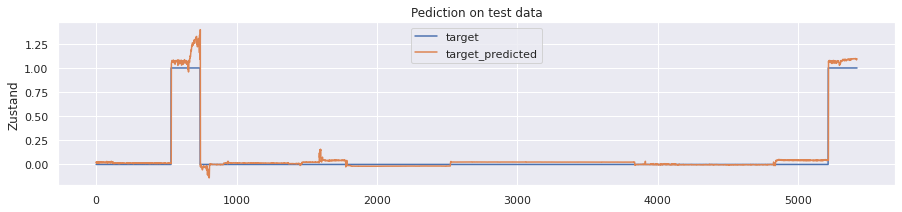

In [31]:
# make a prediction
[yhat,yclass] = model.predict(val_X)    
Yclass=[np.argmax(yclass[i],0) for i in range(len(yclass))] # get final class

plot_signal_hat(yhat,val_Y,saving=True, name='Prediction_Signal_fapi3_42_'+ str(Future))

上圖 validate data 的驗證圖示化，橘色部分為預測線圖，藍色部分為保養需求發生的設定線，透過特徵值的學習，其預測結果是理想的。

In [32]:
aaa = train_X[:,0,:]
aaa.shape

(9500, 11)

In [33]:
train_Y.shape

(9500,)

## 以下為評估模型的表現

In [34]:
# training metrics
scores = model.evaluate(train_X, [train_Y, train_Y_Hot], verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[3]))

48/48 [==============================] - 0s 3ms/step - loss: 0.0175 - signal_out_loss: 0.0121 - class_out_loss: 0.0054 - class_out_acc: 0.9992
Accurracy: 0.9991579055786133


In [35]:
scores

[0.017537357285618782,
 0.012145415879786015,
 0.005391940474510193,
 0.9991579055786133]

In [36]:
# 混淆矩陣 confusion matrix

[yhat,yclass] = model.predict(train_X)

y_pred = (yhat > 0.5).astype("int32")
y_true = train_Y
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[9094,    4],
       [   4,  398]])

In [37]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9900497512437811 
 recall =  0.9900497512437811


In [38]:
train_df2 = df_all_0[df_all_0['id']==7]  
aaa = pd.merge(train_df2, data_x, left_index=True, right_index=True)
bbb = pd.merge(aaa, data_y, left_index=True, right_index=True)
train_X2 = aaa.iloc[:,24:35]
train_X2 =train_X2.values
scaler=MinMaxScaler().fit(train_X2)
train_X2=scaler.transform(train_X2) 
train_X2=reshape_for_Lstm(train_X2)

[yhat,yclass] = model.predict(train_X2)

## 劃出每個生產批次的保養時間預測與實際需求比較 (train, test)

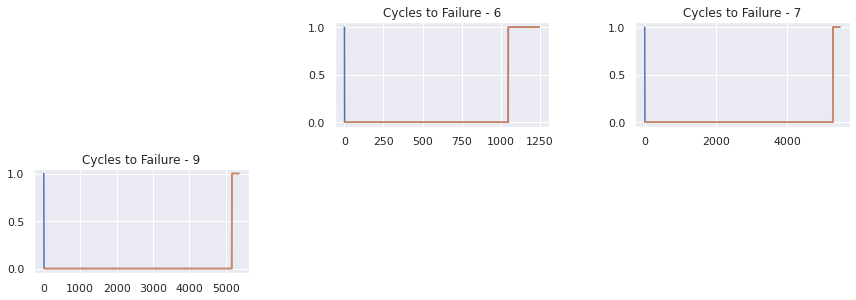

In [44]:
# 劃出每個生產批次的保養時間預測與實際需求比較
# Plot expected cycles before failure for some of the engines in our data set

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

for i in [6,7,9]:
    
    train_df2 = df_all_0[df_all_0['id']==i]  

    aaa = pd.merge(train_df2, data_x, left_index=True, right_index=True)
    bbb = pd.merge(aaa, data_y, left_index=True, right_index=True)
    train_X2 = aaa.iloc[:,24:35]
    train_X2 =train_X2.values
    scaler=MinMaxScaler().fit(train_X2)
    train_X2=scaler.transform(train_X2) 
    train_X2=reshape_for_Lstm(train_X2)

    
    [yhat,yclass] = model.predict(train_X2)
    y_pred2 = (yhat > 0.6).astype("int32")

    result = pd.DataFrame(y_pred2)
    plt.subplot(4, 4, i)
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.title("Cycles to Failure - " + str(i))
    plt.title("Cycles to Failure - " + str(i))
    plt.plot(result)

    plt.plot(bbb.iloc[:,-1].reset_index(drop=True))

    

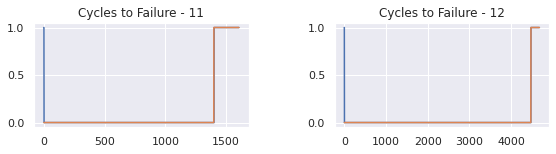

In [46]:
plt.figure(figsize=(20, 10))

for i in [11,12]:
    test_df2 = df_all_0[df_all_0['id']==i]  

    aaa = pd.merge(test_df2, data_x, left_index=True, right_index=True)
    bbb = pd.merge(aaa, data_y, left_index=True, right_index=True)
    train_X2 = aaa.iloc[:,24:35]
    train_X2 =train_X2.values
    scaler=MinMaxScaler().fit(train_X2)
    train_X2=scaler.transform(train_X2) 
    train_X2=reshape_for_Lstm(train_X2)

    
    [yhat,yclass] = model.predict(train_X2)
    y_pred2 = (yhat > 0.6).astype("int32")

    result = pd.DataFrame(y_pred2)
    plt.subplot(4, 4, i)
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.title("Cycles to Failure - " + str(i))
    plt.title("Cycles to Failure - " + str(i))
    plt.plot(result)

    plt.plot(bbb.iloc[:,-1].reset_index(drop=True))

